In [277]:
# --------------------------------------------------------------
#
# L'objectif du present notebook est de tester le telechargement d'images de sentinel ainsi que quelques 
# algorithmes de machine learning ayant trait à la télédetection
# voir le tutoriel https://documentation.dataspace.copernicus.eu/notebook-samples/sentinelhub/data_download_process_request.html
# S'inscrire sur https://shapps.dataspace.copernicus.eu/dashboard/#/account/settings et générer un jetton
# ----------------------------------------------------------------

In [2]:
# l'api accessible depuis "https://scihub.copernicus.eu/dhus" n'est plus disponible (depuis 2023)

In [15]:
# Installer les packages manquantes (si necessaire)
# ! pip install oauthlib;
# ! pip install requests_oauthlib;
# ! pip install sentinelhub;
# ! pip install ipyleaflet;
# ! pip install utils;

In [14]:
# ! pip install folium 
# Pour l'affichage de l'image apres téléchargement

In [13]:
# Downgrader NumPy version 1 , sentinelhub oblige
# ! pip install "numpy<2"

In [1]:
import os
from dotenv import load_dotenv
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

import datetime,getpass
import matplotlib.pyplot as plt
import numpy as np # Actuellement sentinelhub necessite Numpy 1.x
from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)


In [2]:
# recuperation des identifiant depuis le .env (voir ReadMe)
load_dotenv()
SH_CLIENT_ID = os.getenv("SH_CLIENT_ID")
SH_CLIENT_SECRET = os.getenv("SH_CLIENT_SECRET")

In [268]:
#SH_CLIENT_ID

# Authentification

In [152]:
# Ne pas executer la partie authentification plusieurs fois afin d'economiser de la ressource

In [279]:
# Se référer à deforestation_monitoring_with_xarray.ipynb present dans jupyterhub.dataspace.copernicus.eu
your_profil_name="kenpachi_sn" # se trouve dans https://apps.sentinel-hub.com/dashboard/#/account/settings

# Only run this cell if you have not created a configuration.

config = SHConfig()
config.sh_client_id = SH_CLIENT_ID
config.sh_client_secret = SH_CLIENT_SECRET
#config.sh_token_url = "https://services.sentinel-hub.com/oauth/token"
#config.sh_base_url = "https://services.sentinel-hub.com"


config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save(your_profil_name) 

In [5]:
# Si vous avez deja configurer votre profil :
your_profil_name="kenpachi_sn"
config = SHConfig(your_profil_name) 

# Définition de la zone d'intérêt

In [178]:

# https://documentation.dataspace.copernicus.eu/notebook-samples/sentinelhub/data_download_process_request.html
# http://bboxfinder.com/ # pour selectionner la zone

In [62]:
kafountine_coords_wgs84_EPSG4326 = (-14.639385,12.684276,-14.574669,12.749061)
resolution =10 # La resolution de l'image en métre
kafountine_bbox =BBox(bbox=kafountine_coords_wgs84_EPSG4326, crs=CRS.WGS84)
kafountine_size =bbox_to_dimensions(kafountine_bbox, resolution=resolution)
print(f"Image shape at {resolution} m resolution: {kafountine_size} pixels") # Pour une requête API Process, la limite est de 2 500 x 2 500 pixels.

Image shape at 10 m resolution: (702, 717) pixels


### si nous disposons d'un geojson de la zone :
import geopandas as gpd
geojson_path = "chemin/vers/ton_fichier.geojson"
gdf = gpd.read_file(geojson_path)

minx, miny, maxx, maxy = gdf.total_bounds
kafountine_coords_wgs84_EPSG4326 = (minx, miny, maxx, maxy)

resolution = 10
kafountine_bbox = BBox(bbox=kafountine_coords_wgs84_EPSG4326, crs=CRS.WGS84)
kafountine_size = bbox_to_dimensions(kafountine_bbox, resolution=resolution)

# Télécharger une image "True color" format PNG pour une date donnée

In [240]:
# Nous nous interessons aux bandes  B02 ,B03 et B04 de Sentinel-2 L1C
# Sans paramètres supplémentaires dans le script d'évaluation, les données téléchargées correspondront aux valeurs de réflectance au UINT8format
# (valeurs comprises entre 0 et 255).Donc pas de probleme d'affichage avec matplotlib

In [37]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                "s2", service_url=config.sh_base_url
            ),
            time_interval=("2022-10-12", "2025-02-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=kafountine_bbox,
    size=kafountine_size,
    config=config,
)

In [11]:
print([collection.name for collection in DataCollection])

['SENTINEL2_L1C', 'SENTINEL2_L2A', 'SENTINEL1', 'SENTINEL1_IW', 'SENTINEL1_IW_ASC', 'SENTINEL1_IW_DES', 'SENTINEL1_EW', 'SENTINEL1_EW_ASC', 'SENTINEL1_EW_DES', 'SENTINEL1_EW_SH', 'SENTINEL1_EW_SH_ASC', 'SENTINEL1_EW_SH_DES', 'DEM', 'DEM_MAPZEN', 'DEM_COPERNICUS_30', 'DEM_COPERNICUS_90', 'MODIS', 'LANDSAT_MSS_L1', 'LANDSAT_TM_L1', 'LANDSAT_TM_L2', 'LANDSAT_ETM_L1', 'LANDSAT_ETM_L2', 'LANDSAT_OT_L1', 'LANDSAT_OT_L2', 'SENTINEL5P', 'SENTINEL3_OLCI', 'SENTINEL3_SLSTR', 'HARMONIZED_LANDSAT_SENTINEL', 's2']


In [39]:
true_color_imgs = request_true_color.get_data() # image sous format tableau numpy

In [34]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (20, 21, 3)


<p style="color: red; font-size: 30px;">Attention à la date de collecte des images </p>

En fonction de la date chosie, l'image en sortie peut être noir , se servir de la plateforme https://browser.dataspace.copernicus.eu/ pour le choix des dates

In [21]:
true_color_imgs[0]

array([[[21, 11,  2],
        [22, 15,  3],
        [22, 13,  3],
        ...,
        [14, 10,  2],
        [15, 12,  1],
        [20, 15,  4]],

       [[20, 12,  3],
        [22, 13,  4],
        [24, 15,  3],
        ...,
        [14, 14,  3],
        [15, 17,  2],
        [21, 17,  5]],

       [[18, 13,  1],
        [21, 13,  3],
        [28, 16,  6],
        ...,
        [21, 19,  3],
        [22, 20,  5],
        [24, 19,  6]],

       ...,

       [[18, 15,  2],
        [16, 13,  1],
        [17, 14,  0],
        ...,
        [45, 33, 27],
        [39, 30, 21],
        [42, 30, 21]],

       [[16, 15,  2],
        [16, 15,  2],
        [17, 15,  2],
        ...,
        [43, 31, 23],
        [40, 30, 22],
        [41, 31, 23]],

       [[19, 17,  3],
        [22, 17,  6],
        [20, 17,  5],
        ...,
        [43, 31, 23],
        [42, 30, 23],
        [44, 32, 25]]], dtype=uint8)

In [23]:
import folium
map = folium.Map(location=[(kafountine_coords_wgs84_EPSG4326[1] + kafountine_coords_wgs84_EPSG4326[3]) / 2, (kafountine_coords_wgs84_EPSG4326[0] + kafountine_coords_wgs84_EPSG4326[2]) / 2], zoom_start=15)
folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    attr="Google",
    name="Google Satellite",
    overlay=False,
    control=True
).add_to(map)
folium.raster_layers.ImageOverlay(
    image=true_color_imgs[0],
    bounds=[[kafountine_coords_wgs84_EPSG4326[1], kafountine_coords_wgs84_EPSG4326[0]], [kafountine_coords_wgs84_EPSG4326[3], kafountine_coords_wgs84_EPSG4326[2]]],
    opacity=1,
).add_to(map)
folium.Rectangle(
    bounds=[[kafountine_coords_wgs84_EPSG4326[1], kafountine_coords_wgs84_EPSG4326[0]], [kafountine_coords_wgs84_EPSG4326[3], kafountine_coords_wgs84_EPSG4326[2]]],  # Coordinates of the bounding box
    color="orange",  # Color of the rectangle
    weight=4,     # Line thickness
    fill=False    # Set to False to make it a simple outline
).add_to(map)


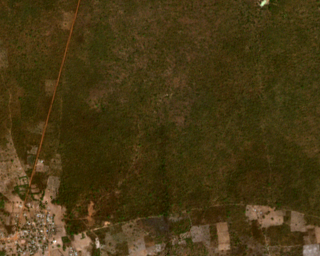

In [25]:
 map

# Image mosaique
permet de combiner plusieurs images disponibles sur une période donnée.
génère une mosaïque, c'est-à-dire une image composite créée à partir de plusieurs prises de vue

In [41]:
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval=("2020-06-01", "2020-07-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=kafountine_bbox,
    size=kafountine_size,
    config=config,
)
all_images = request_true_color.get_data()
print(f"Nombre d'images récupérées : {len(all_images)}")

Nombre d'images récupérées : 1


unique


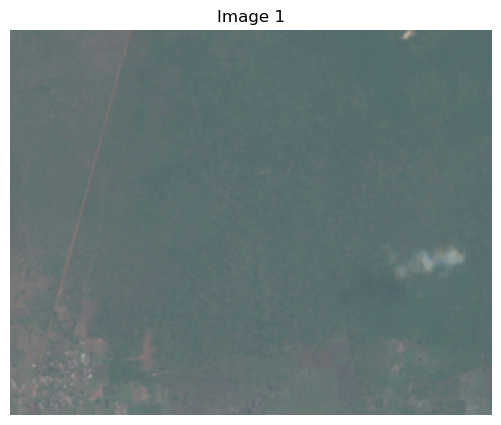

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def afficher_images(images, factor=3.5 / 255, clip_range=(0, 1)):
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(15, 5))  # Crée un affichage adapté au nombre d'images

    # Si une seule image, `axes` ne sera pas une liste → Correction
    if len(images) == 1:
        axes = [axes]
        print("unique")

    for i, image in enumerate(images):
        image = np.clip(image * factor, clip_range[0], clip_range[1])  # Ajuste luminosité et contraste
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"Image {i+1}")

    plt.show()

# Récupérer toutes les images et les afficher correctement
all_images = request_true_color.get_data()  
afficher_images(all_images)

# Recupérer toutes les bandes spectrales brutes de sentinel 2

In [52]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

request_all_bands = SentinelHubRequest(
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval=("2020-06-01", "2020-06-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=kafountine_bbox,
    size=kafountine_size,
    config=config,
)

In [55]:
all_bands_response = request_all_bands.get_data()

# Enregistrer et lecture sur disque dure

In [58]:
request_all_bands = SentinelHubRequest(
    data_folder="test_dir",
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval=("2020-06-01", "2020-06-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=kafountine_bbox,
    size=kafountine_size,
    config=config,
)

In [383]:
%%time
all_bands_img = request_all_bands.get_data(save_data=True)
print(
    "The output directory has been created and a tiff file with all 13 bands was saved into the following structure:\n"
)

for folder, _, filenames in os.walk(request_all_bands.data_folder):
    for filename in filenames:
        print(os.path.join(folder, filename))

CPU times: total: 141 ms
Wall time: 8.05 s


In [385]:
%%time
# try to re-download the data
all_bands_img_from_disk = request_all_bands.get_data()

CPU times: total: 15.6 ms
Wall time: 73.8 ms


In [387]:
%%time
# force the redownload
all_bands_img_redownload = request_all_bands.get_data(redownload=True)

CPU times: total: 93.8 ms
Wall time: 8.76 s


## Enregistrement sur disque dure

La get_dataméthode renvoie une liste de tableaux numpy et permet d'enregistrer les données téléchargées sur le disque, comme indiqué dans l'exemple précédent. Il est parfois plus pratique d'enregistrer directement les données sur le disque. Vous pouvez le faire en utilisant save_datala méthode.

In [391]:
%%time
request_all_bands.save_data()

CPU times: total: 0 ns
Wall time: 2.01 ms


In [393]:
print(
    "The output directory has been created and a tiff file with all 13 bands was saved into the following structure:\n"
)

for folder, _, filenames in os.walk(request_all_bands.data_folder):
    for filename in filenames:
        print(os.path.join(folder, filename))

The output directory has been created and a tiff file with all 13 bands was saved into the following structure:

test_dir\9a01a4c95afb079380dd5e8e11ac0628\request.json
test_dir\9a01a4c95afb079380dd5e8e11ac0628\response.tiff


#  Créer des images mensuelles les moins nuageuses pour l'année 2019

In [45]:
import datetime
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2019, 12, 31)
n_chunks = 13
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

Monthly time windows:

('2019-01-01', '2019-01-29')
('2019-01-29', '2019-02-26')
('2019-02-26', '2019-03-26')
('2019-03-26', '2019-04-23')
('2019-04-23', '2019-05-21')
('2019-05-21', '2019-06-18')
('2019-06-18', '2019-07-16')
('2019-07-16', '2019-08-13')
('2019-08-13', '2019-09-10')
('2019-09-10', '2019-10-08')
('2019-10-08', '2019-11-05')
('2019-11-05', '2019-12-03')


In [47]:
def get_true_color_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C.define_from(
                    "s2l1c", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=kafountine_bbox,
    size=kafountine_size,
    config=config,
    )

In [49]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(
    list_of_requests, max_threads=5
)

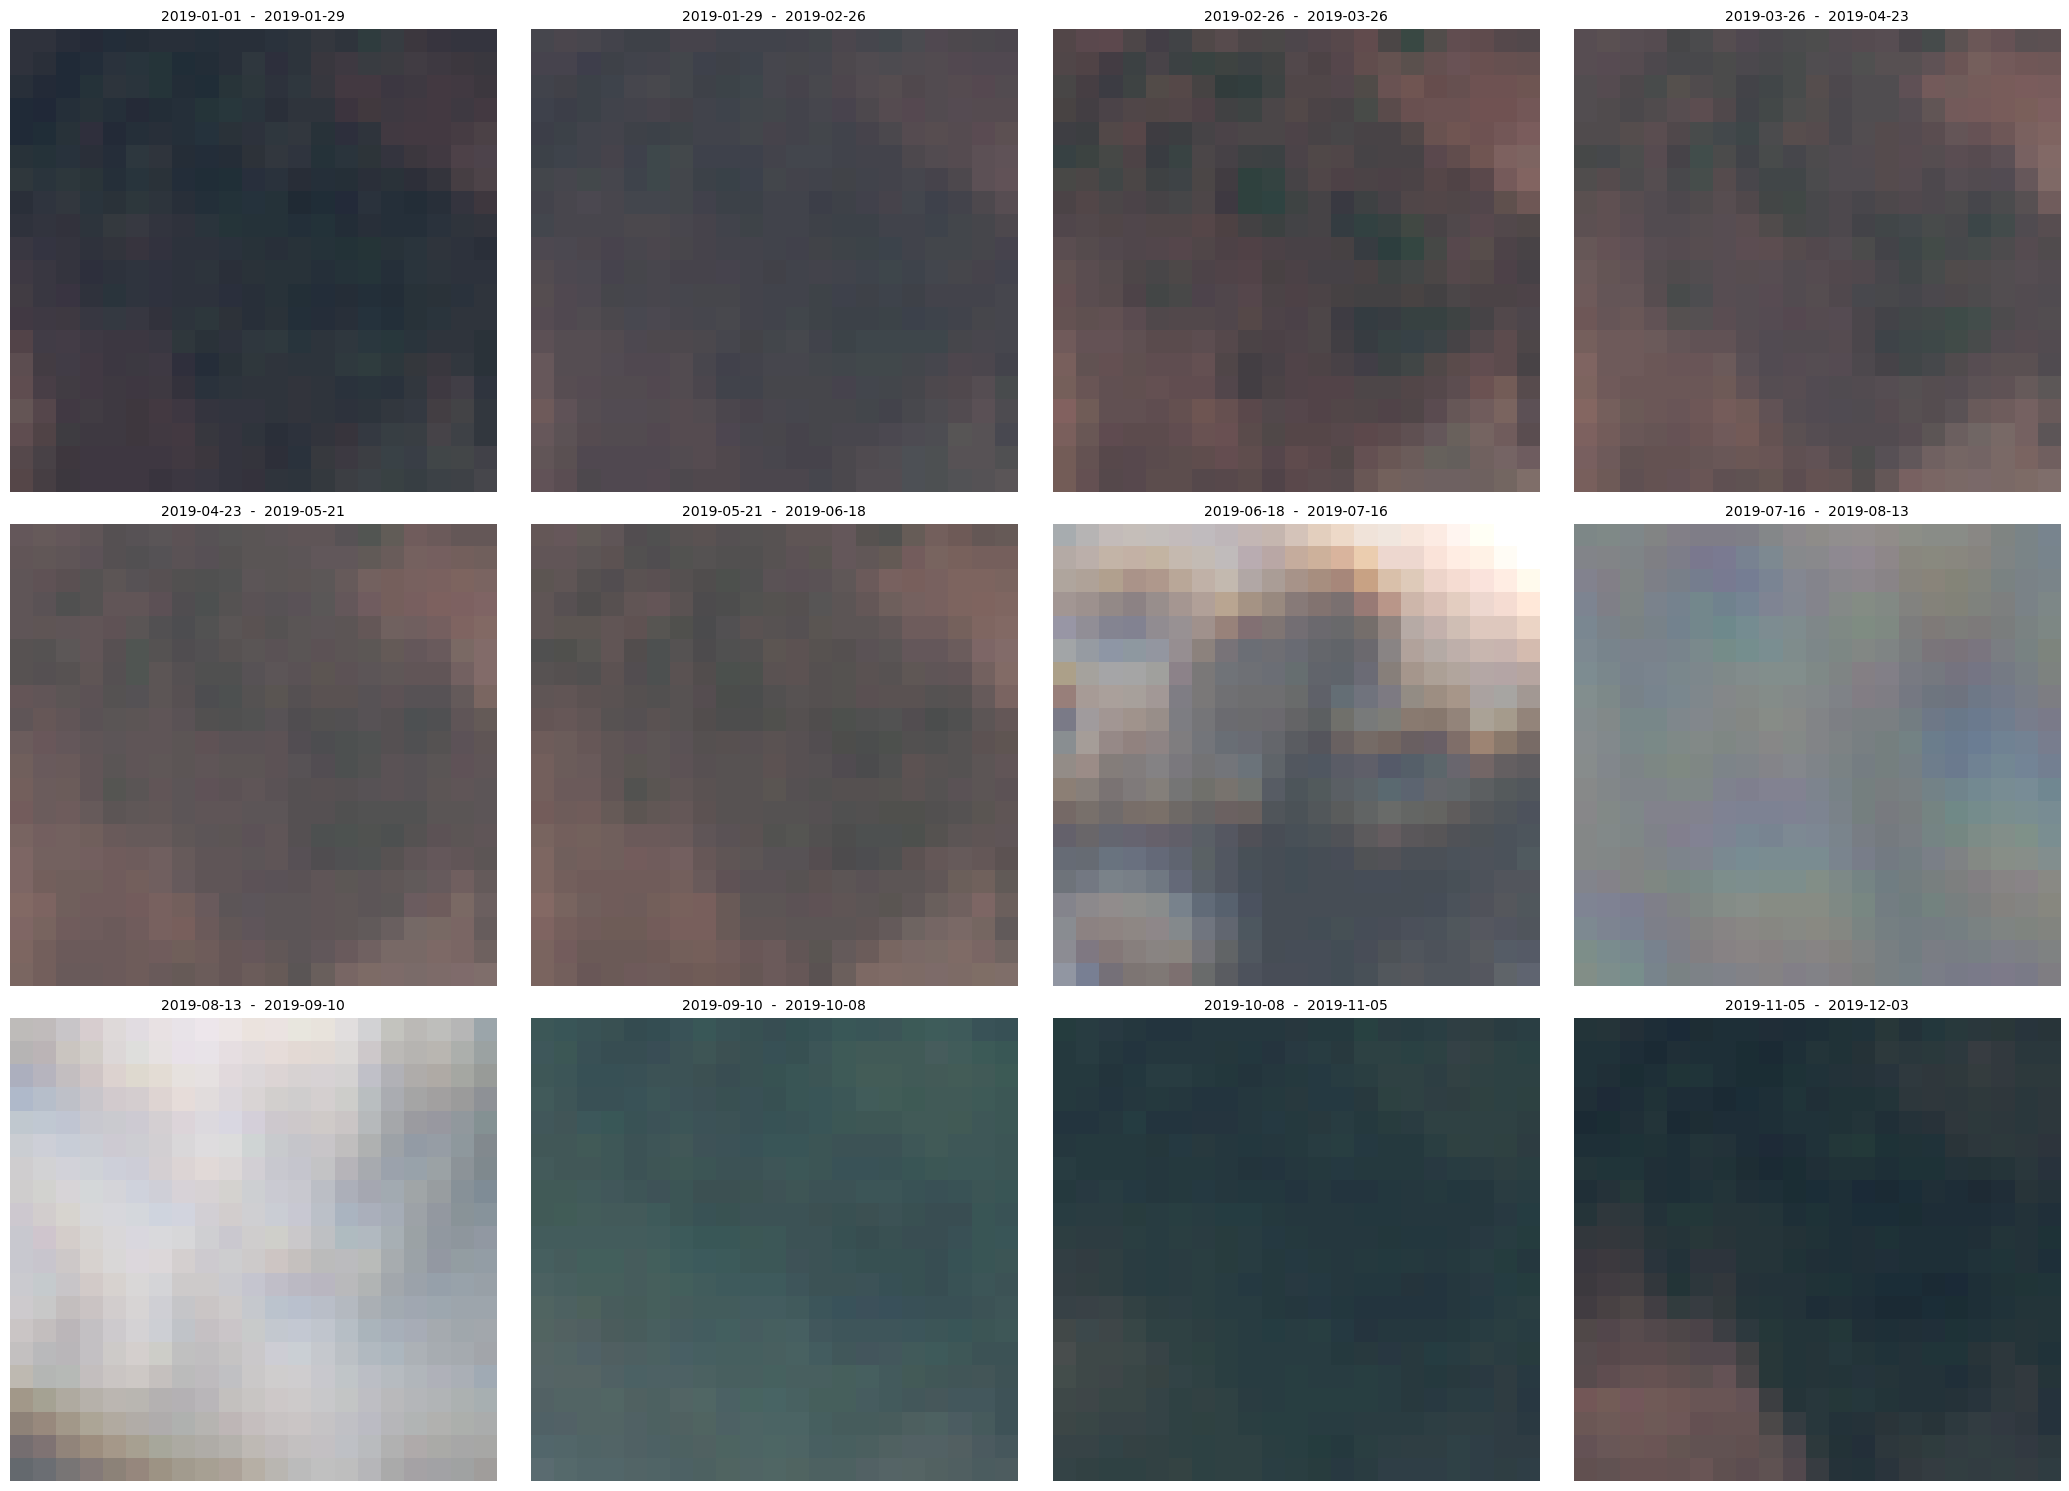

In [420]:
# some stuff for pretty plots
ncols = 4
nrows = 3
aspect_ratio = kafountine_size[0] / kafountine_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(5 * ncols * aspect_ratio, 5 * nrows),
    subplot_kw=subplot_kw,
)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()

# Image NDVI

In [64]:
evalscript_NDVI = """
// VERSION=3
function setup() {
    return {
        input: [{
            bands: ["B08", "B04"]
        }],
        output: {
            id: "default",
            bands: 1,
            sampleType: "FLOAT32"  // Pour récupérer des valeurs NDVI précises
        }
    };
}

function evaluatePixel(sample) {
    let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
    return [ndvi];
}
"""

request_ndvi = SentinelHubRequest(
    evalscript=evalscript_NDVI,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                "s2", service_url=config.sh_base_url
            ),
            time_interval=("2022-10-12", "2025-02-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)], 
    bbox=kafountine_bbox,
    size=kafountine_size,
    config=config,
)


In [78]:
# Telechargement de l'image ndvi
ndvi_data = request_ndvi.get_data()[0] 

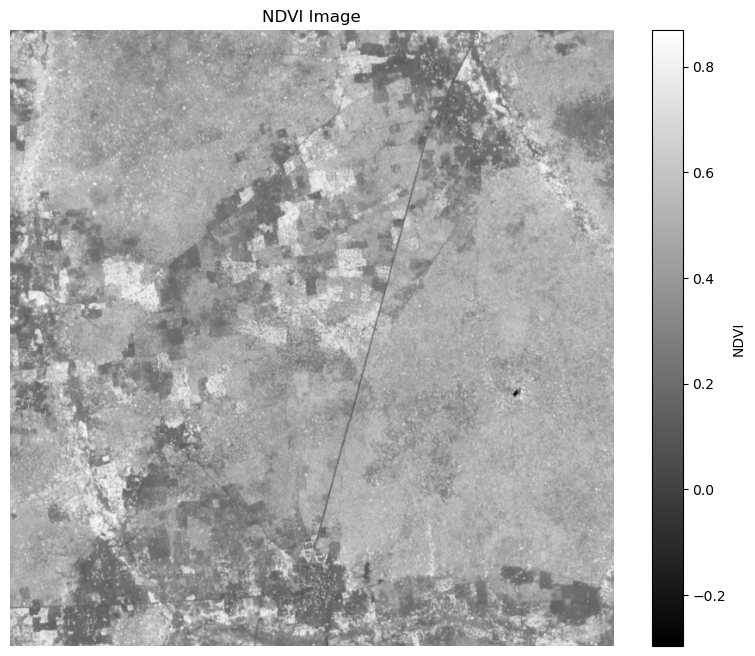

In [84]:
# Visualisation
plt.figure(figsize=(10, 8))
plt.imshow(ndvi_data, cmap="gray")  # Niveaux de gris
plt.colorbar(label="NDVI")  # Barre des valeurs
plt.title("NDVI Image")
plt.axis("off")
plt.show()